# ADMIXTURE

## General Settings

In [31]:
% matplotlib inline
% load_ext autoreload
% autoreload 2

% run general_settings.py
# ^ Takes ~20s to run if it finds the dumpfiles
# ^ WARNING: It will hog ~2.02 Gb RAM

% run datasets_settings.py
# ^ Will take another ~20s

! echo; wc -l /home/juan/tesina/dataset_dumps/*.samples

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[11:06:00] 'panels' dict
[11:06:00] 'galanter', 'present', 'missing' dataframes
[11:06:00] 'panel_labels'
[11:06:00] 'panel_names' dict
[11:06:00] 'panel_rsIDs' dict
[11:06:00] 'genome' dataframe
[11:06:06] 'lat' dataframe
[11:06:20] 'control_genotypes' huge datagrame
[11:06:20] 'control_rsIDs' dict to filter it ^
[11:06:20] 'cp_factors' list
[11:06:20] 'control_labels'
[11:06:20] 'control_names' dict
[11:06:20] 'df_1000G_samples'
[11:06:20] 'df_1000G_SNPs'
[11:06:20] 'df_1000G_genotypes'
[11:06:20] 'df_1000G_populations'
[11:06:20] 'df_1000G_genotypes_alleles'

/home/juan/repos/tesina/settings/genome.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  centromers["chromosome"] = [i.replace("CEN", "") for i in centromers.index]
/home/juan/anaconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1588: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())



[11:06:20] 'mafs' dataframe
[11:06:20] 'dataset_names'
[11:06:20] 'dataset_populations'
[11:06:20] 'dataset_samples' created and written to files

  346 /home/juan/tesina/dataset_dumps/L.samples
  544 /home/juan/tesina/dataset_dumps/LE.samples
  751 /home/juan/tesina/dataset_dumps/LEA.samples
  959 /home/juan/tesina/dataset_dumps/LEAC.samples
 1062 /home/juan/tesina/dataset_dumps/LEACI.samples
 3662 total


/home/juan/anaconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1590: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


* En `./dataset_dumps/` están los archivos `*.samples` con los sample IDs de 1000 Genomas para cada dataset (`L`, `LE`, `LEA` ...).
* En el mismo directorio copié los bfiles (`.bed`, `.bim` ...) de PLINK de cada panel (GALs y CPs).
* Ahí mismo corrí `./1_create_datasets_run_admixture.sh <nombre-de-panel> <nombre-de-panel-2> ..`
* -> Se crean automáticamente directorios por cada combineta de dataset + panel con los archivos `*.P`
* antes corrí `./0_bring_the_panel_bedfiles.sh` y luego `3_generate` ...

## CV Errors

### Plot the CV errors per dataset / per panel

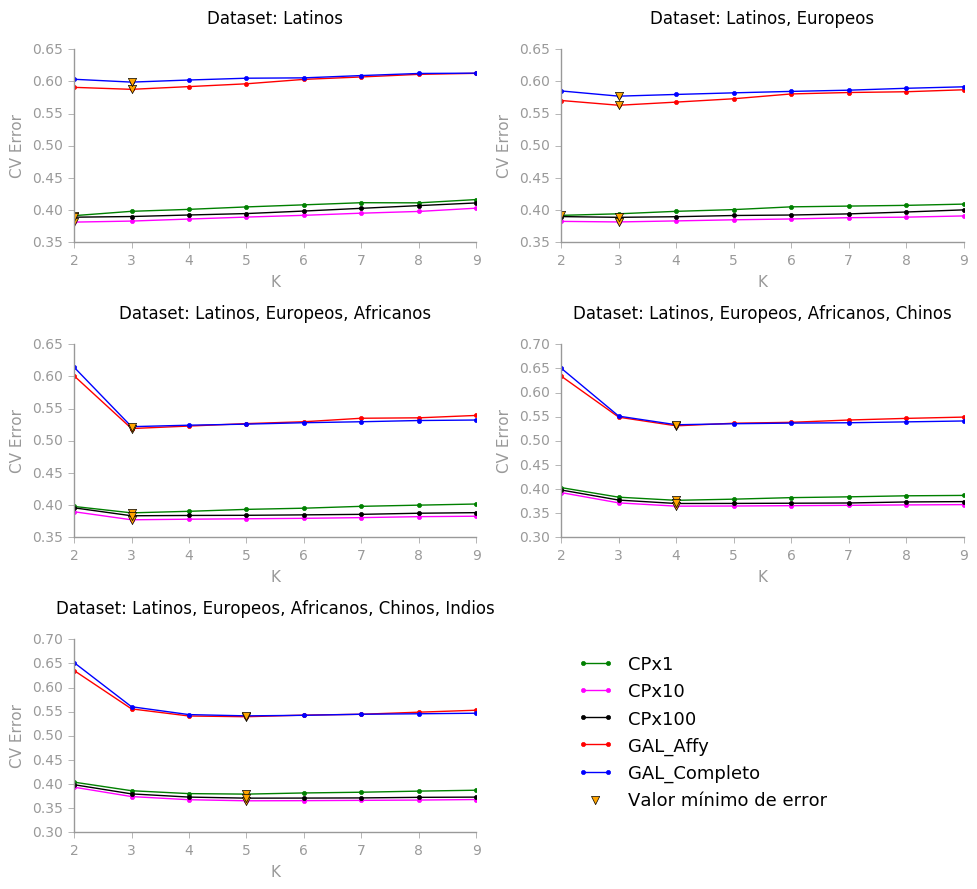

In [4]:
from plotters.admixture_cv_errors import AdmixtureCVErrors

admixture_cv_errors = AdmixtureCVErrors()
cv_errors = admixture_cv_errors.read_cv_errors()
admixture_cv_errors.plot()

## Ancestry ratios per population (mean) and per individual sample

In [2]:
%%time
# 20s to run this cell if only_optimal_Ks=True

from admixture.results import AdmixtureResults

admix_results = AdmixtureResults()
ancestries_df = admix_results.read_ancestry_files(only_optimal_Ks=False)

CPU times: user 10 s, sys: 60 ms, total: 10.1 s
Wall time: 10.5 s


In [ ]:
# 3m 4s to run

import seaborn as sns
from plotters.admixture_ancestries import AdmixtureAncestries

sns.set_context("talk")
sns.set_style("white")

admix_plotter = AdmixtureAncestries()

# # debug or show as example
# K, p, d = 5, "CPx100", "LEACI"
# admix_plotter.plot_per_sample(d, K, p, ancestries_df)
# admix_plotter.plot_population_means(d, K, p, ancestries_df)

# Rerun this line in case you wanna replot population ancestries means:
admix_plotter.plot_all(ancestries_df)

In [ ]:
from IPython.display import Image
from os.path import join

panel, dataset, K = "CPx100", "LEACI", 9
filedir = "/home/juan/tesina/charts/ADMIXTURE/"
filename = "{0}__{1}/{1}__{0}__{2}".format(panel, dataset, K)

Image(join(filedir, filename + "__means.png"))

In [ ]:
Image(join(filedir, filename + "__samples.png"))

# Ternary plots

In [130]:
df.xs("GAL_Completo", level="panel").reset_index(drop=True).set_index("population")

,AFR,EAS,EUR,SAS,gender,sample,super_population,3,4,AMR,7,1,2,5,6,0,8
population,,,,,,,,,,,,,,,,,
GBR,0.000010,0.023393,0.538746,0.071322,male,HG00096,EUR,NaN,NaN,0.043260,NaN,0.020225,0.157274,NaN,0.001652,NaN,0.144116
GBR,0.000010,0.039000,0.593382,0.023116,female,HG00097,EUR,NaN,NaN,0.078909,NaN,0.001189,0.189266,NaN,0.000010,NaN,0.075119
GBR,0.000010,0.023012,0.584459,0.042068,female,HG00099,EUR,NaN,NaN,0.004588,NaN,0.000010,0.135893,NaN,0.102865,NaN,0.107095
GBR,0.000010,0.038222,0.563062,0.104939,female,HG00100,EUR,NaN,NaN,0.000010,NaN,0.076615,0.000010,NaN,0.046518,NaN,0.170614
GBR,0.000010,0.000010,0.677503,0.087866,male,HG00101,EUR,NaN,NaN,0.000010,NaN,0.069397,0.135732,NaN,0.029462,NaN,0.000010
GBR,0.000010,0.021554,0.471675,0.028416,female,HG00102,EUR,NaN,NaN,0.000238,NaN,0.000010,0.108791,NaN,0.097560,NaN,0.271747
GBR,0.000010,0.000010,0.455487,0.000010,male,HG00103,EUR,NaN,NaN,0.028549,NaN,0.046257,0.000010,NaN,0.182188,NaN,0.287480
GBR,0.000010,0.028727,0.517342,0.039635,male,HG00105,EUR,NaN,NaN,0.000010,NaN,0.035412,0.036472,NaN,0.135972,NaN,0.206420
GBR,0.000010,0.000010,0.655470,0.060479,female,HG00106,EUR,NaN,NaN,0.011117,NaN,0.100528,0.076582,NaN,0.000010,NaN,0.095794


/home/juan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


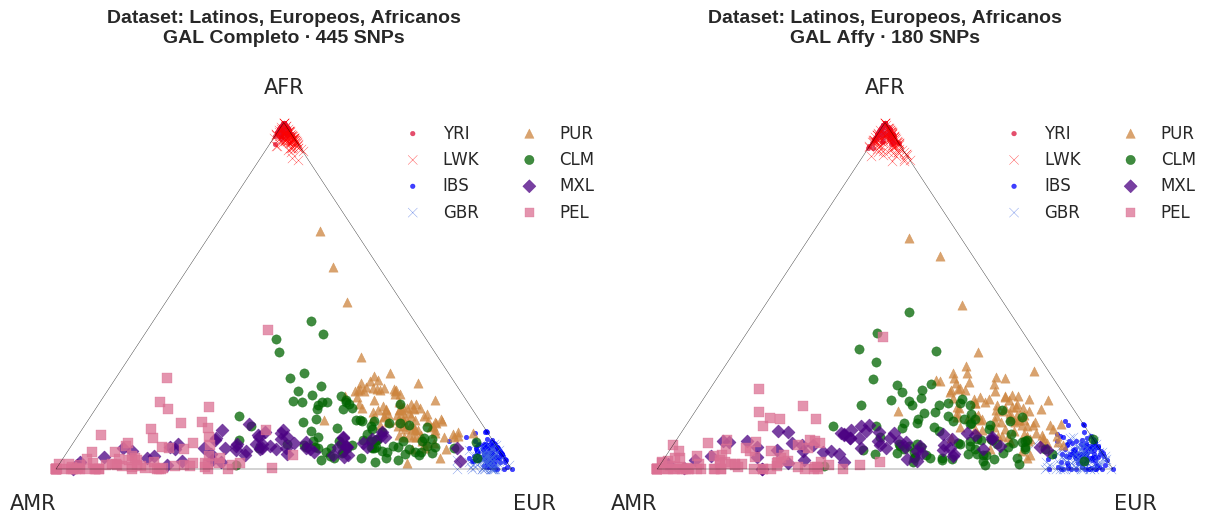

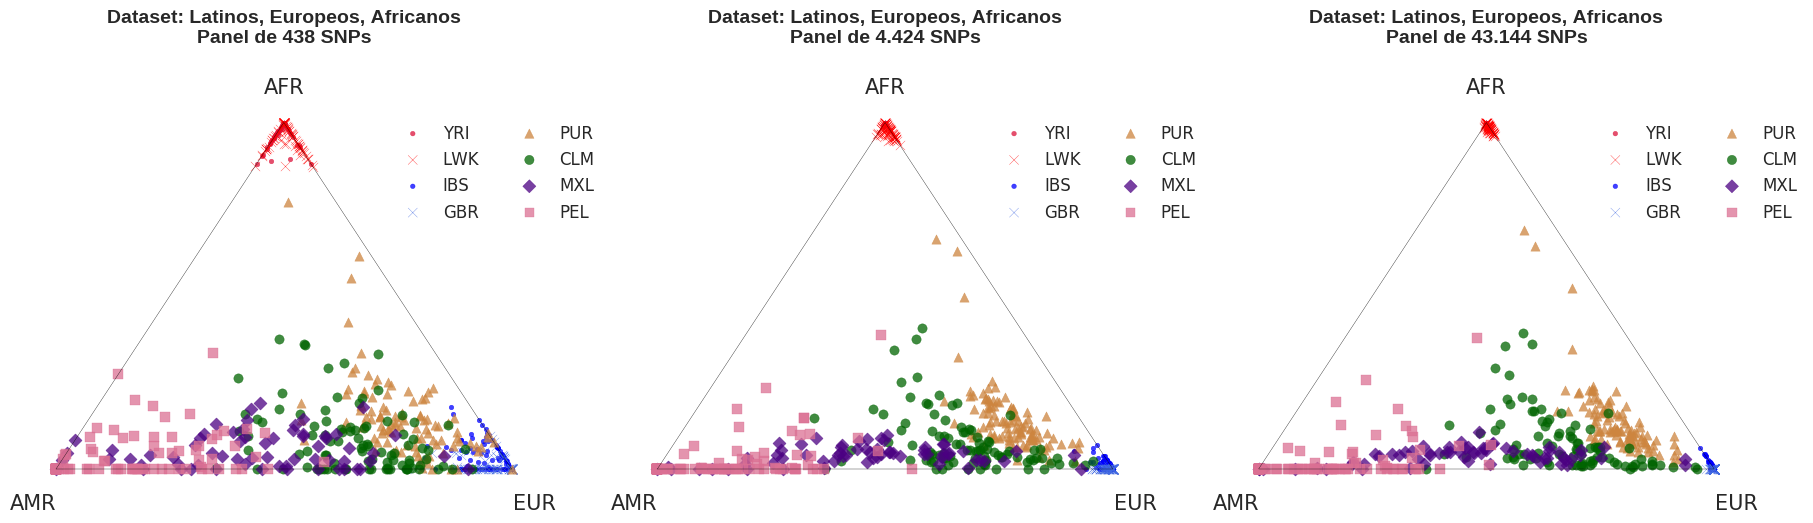

In [236]:
import ternary
import seaborn as sns

from os.path import expanduser, join
from datasets.dataset_creator import DatasetCreator
from panels.panel_creator import PanelCreator
from helpers.plot_helpers import (population_colors,
                                  population_markers,
                                  hide_spines_and_ticks)


sns.set_context("notebook")
sns.set_style("white")


PLOTS_DIR = expanduser("/home/juan/tesina/charts/ternary")

def _ternary_plot_aesthetics(tax, title):
    tax.boundary(linewidth=0.25)
    tax.clear_matplotlib_ticks()
    tax.set_title(title, position=(0.5, 1.15), fontsize=14,
                  fontweight="bold")
    tax.legend(frameon=False, fontsize=12, ncol=2, scatterpoints=1,
               bbox_to_anchor=(1.15, 1))
        
    return tax

population_order = DatasetCreator().populations_plot_order()


def plot_ancestries_triangle(dataset_label, ancestries_df):
    pc = PanelCreator()
    
    Ks = ancestries_df.index.get_level_values("K")
    if any(Ks != 3):
        print("\n== WARNING ==\nYou're trying to plot a ternary of more than 3 ancestries?\n")
        
    datasets = ancestries_df.index.get_level_values("dataset").unique()
    if len(datasets) > 1:
        print("\n== WARNING ==\nYou're trying to plot data from multiple datasets simultaneously?\n")
    
    # One figure per panel group
    for panel_group in [pc.panel_labels(), pc.control_labels()]:

        rows, cols = 1, len(ancestries_df.groupby(level=2))
        width, height = 7.5, 5
        fig = plt.figure(figsize=(cols * width, rows * height))
        ax_ids = (np.arange(rows * cols) + 1).tolist()[::-1]

        # One subplot per panel
        for panel_label in panel_group:
            df_lite = ancestries_df.xs(panel_label, level="panel")
            df_lite = df_lite.reset_index(drop=True).set_index("population")
            
            panel_name = all_panel_names[panel_label]
            dataset_name = dataset_names[dataset_label]
            plot_title = "Dataset: {}\n{}".format(dataset_name, panel_name)

            ax = fig.add_subplot(rows, cols, ax_ids.pop())
            fig, tax = ternary.figure(scale=1, ax=ax)

            df_sorted_by_pop = df_lite.loc[population_order].dropna()
            df_grouped_by_pop = df_sorted_by_pop.groupby(level="population", sort=False)
            
            for population, df_pop in df_grouped_by_pop:
                tax.scatter(df_pop[["EUR", "AFR", "AMR"]].values,
                            label=population, color=population_colors(population),
                            marker=population_markers(population), s=45, alpha=0.75)

            _ternary_plot_aesthetics(tax, plot_title)
            hide_spines_and_ticks(ax, spines="all")

            fontsize = 15

            # EUR, AFR, AMR
            tax.bottom_axis_label(df_masked.columns[0], position=(1, 0, 0), fontsize=fontsize, rotation=0)
            tax.right_axis_label(df_masked.columns[1], position=(-0.1, 1.2, -0.1), fontsize=fontsize, rotation=0)
            tax.left_axis_label(df_masked.columns[2], position=(0, 0, 1), fontsize=fontsize, rotation=0)


        plt.show()
    

K3_mask = (ancestries_df.index.get_level_values("K") == 3)
K3_ancestries_df = ancestries_df[K3_mask]

for (dataset_label, K), df in K3_ancestries_df.groupby(level=["dataset", "K"]):
    df.dropna(axis=1, inplace=True)  # Get rid of null components

    if dataset_label != "LEA":  ###
        continue
    
    plot_ancestries_triangle(dataset_label, df)
    
    
# save the figs to disk
# get this in a plotter class
# run for all